<a href="https://colab.research.google.com/github/yogaliu-ds/Titanic/blob/main/Titanic_modifying.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Titanic Competition


# 1. Import module and data

In [59]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier


import matplotlib.pyplot as plt
import seaborn as sns 


train = pd.read_csv('/content/drive/MyDrive/Kaggle/Titanic/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle/Titanic/test.csv')

# 2. Getting to know your data

In [2]:
#  How many columns
print(train.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [3]:
# Drop unuseful columns
df = train
df = df.drop(columns=['PassengerId', 'Name'])

In [4]:
# Let's see what is 'Ticket' 
print(len(df.Ticket.unique()))

# 681 different value: Ticket doesn't matter, we drop it
df = df.drop(columns = ['Ticket'])

681


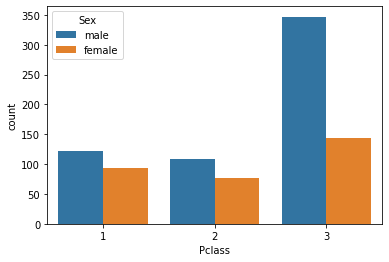

In [15]:
# Pcalss & Sex
pclass_age = df.groupby('Pclass')['Sex'].value_counts()
sns.countplot(data=df, x='Pclass', hue='Sex')
plt.show()

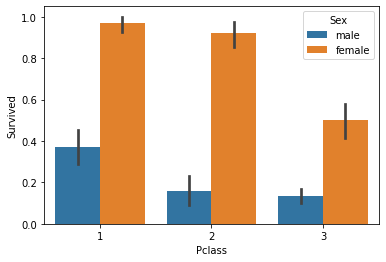

In [14]:
# Survival rate
sns.barplot(x='Pclass', y='Survived', data=df, hue='Sex')
plt.show()

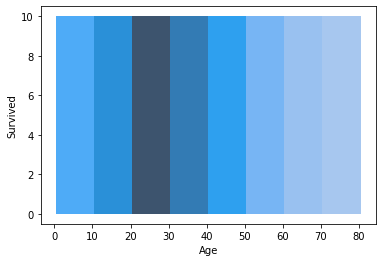

In [16]:
# Age
sns.histplot(data=df, x='Age', y='Survived', binwidth=10)

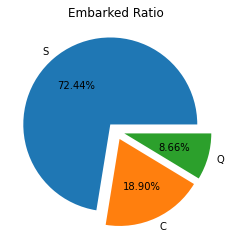

In [39]:
# Embarked
k = df.Embarked.value_counts()
plt.pie(x=k, labels=k.index, explode=[0.1,0.1,0.1], autopct='%1.2f%%')
plt.title('Embarked Ratio')
plt.show()

In [57]:
# Embarked and Pcalss
k = df.groupby('Embarked')['Pclass'].value_counts()
print(k)


Embarked  Pclass
C         1          85
          3          66
          2          17
Q         3          72
          2           3
          1           2
S         3         353
          2         164
          1         127
Name: Pclass, dtype: int64


# 3. Data Preprocessing

In [60]:
# (Pclass) to category
train.Pclass = train.Pclass.astype('category')

# (Embarked) Drop rows with NaN
train.dropna(subset=['Embarked'], inplace=True)

# (Age) fill in sample mean
def Age(cols):
    Age=cols[0]
    Pclass=cols[1]
    if pd.isnull(Age):
        if Pclass==1:
            return 38.23
        elif Pclass==2:
            return 29.87
        elif Pclass==3:
            return 25.14
    else:
        return Age
    

train["Age"]=train[["Age","Pclass"]].apply(Age,axis=1)



# (Cabin) change into boolean
train.Cabin = train.Cabin.isna()
train.Cabin = train.Cabin.replace({True:1, False:0})


# 4. Pipeline

In [61]:
# Eliminate columns unrelated to prediction
train_temp = train.drop(columns=['Name', 'PassengerId', 'Ticket'], axis=1)

# Get dummies
train_temp = pd.get_dummies(train_temp, drop_first=False)

# Scaling
scaler = StandardScaler()

# Normalizer
normalizer = Normalizer()

# RandomForest
rf = RandomForestClassifier()

# GridSearchCV
param = {'n_estimators':[100], 'max_features':['sqrt', 'log2'], 'max_depth' : [6]}
search = GridSearchCV(estimator = rf, param_grid = param,  n_jobs=-1, scoring='accuracy', cv=5)

# Pipeline
pipe = make_pipeline(scaler,  search)

# Set X, y from train_temp
X = train_temp.iloc[:, 1:]
y = train_temp.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 21)

# fit
pipe.fit(X_train, y_train)

# predict
y_pred = pipe.predict(X_test)

# Accuracy
score = accuracy_score(y_test, y_pred)
print(score)

# Cross_val_score, see the average performence
cross_score = cross_val_score(pipe, X_train, y_train, cv=3)

print(cross_score.mean())

0.8258426966292135
0.8030942334739803


<class 'list'>


# 5. Submit

5-1 Test data preprocessing

In [ ]:
# (Pclass) to category
test.Pclass = test.Pclass.astype('category')

# (Embarked) Drop rows with NaN
# test.dropna(subset=['Embarked'], inplace=True)

# (Age) fill in sample mean
def Age(cols):
    Age=cols[0]
    Pclass=cols[1]
    if pd.isnull(Age):
        if Pclass==1:
            return 38.23
        elif Pclass==2:
            return 29.87
        elif Pclass==3:
            return 25.14
    else:
        return Age
    

test["Age"]=test[["Age","Pclass"]].apply(Age,axis=1)



# (Cabin) change into boolean
test.Cabin = test.Cabin.isna()
test.Cabin = test.Cabin.replace({True:1, False:0})

# (Fare)
test.Fare = test.Fare.fillna(test['Fare'].mean())

5-2 Get the prediction

In [ ]:
# Save the PassengerId, we'll use it in the submission
test_id = test['PassengerId']

# 
test_temp = test.drop(columns=['Name', 'PassengerId', 'Ticket'], axis=1)

test_temp = pd.get_dummies(test_temp)

test_pred = pipe.predict(test_temp)

print(type(test_pred))

<class 'numpy.ndarray'>


In [ ]:
# Combine 2 array to a df
result = np.array([test_id, test_pred])

# Transpose
result = pd.DataFrame(result).T

# Assign column names
result.columns = ['PassengerId', 'Survived']
print(result.head())

# Save to disk
result.to_csv('titanic_pred.csv', index=False)

# Check after saving to disk
test_csv = pd.read_csv('/content/titanic_pred.csv')
print(test_csv)

   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1
     PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]
